# Titanic - Machine Learning from Disaster

- Vamos utilizar os [dados disponíveis no Kaggle](https://www.kaggle.com/competitions/titanic)
    - É um dataset de **competição**
    - O resultado é avaliado através da **acurácia**:
        - _"Sua pontuação é a porcentagem de passageiros que você prevê corretamente. Isso é conhecido como acurácia."_

In [2]:
import pandas as pd

In [3]:
treino = pd.read_csv('train.csv')

In [4]:
teste = pd.read_csv('test.csv')

> Como já houve uma tentativa para esse desafio, vamos apenas replicar algumas etapas e tentar melhorar a precisão de nossa previsão.

In [5]:
# Eliminando as colunas com elevada cardinalidade
treino = treino.drop(['Name','Ticket','Cabin'],axis=1)
teste = teste.drop(['Name','Ticket','Cabin'],axis=1)

In [6]:
# Usando a mediana para imputar os valores nulos na coluna de idade
treino.loc[treino.Age.isnull(),'Age'] = treino.Age.median()
teste.loc[teste.Age.isnull(),'Age'] = teste.Age.median()

In [7]:
# Tratando a coluna Embarked da base de treino usando a moda 
treino.loc[treino.Embarked.isnull(),'Embarked'] = treino.Embarked.mode()[0]

In [8]:
# E também a coluna Fare da base de teste usando a média
teste.loc[teste.Fare.isnull(),'Fare'] = teste.Fare.mean()

In [9]:
treino.dtypes=='object'

PassengerId    False
Survived       False
Pclass         False
Sex             True
Age            False
SibSp          False
Parch          False
Fare           False
Embarked        True
dtype: bool

In [10]:
treino.columns[treino.dtypes=='object']

Index(['Sex', 'Embarked'], dtype='object')

In [11]:
treino.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [12]:
treino.Embarked.value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

### Variável Sex

Vamos transformar a coluna Sex código númerico para que a coluna possa ser usada no modelo de aprendizagem

In [13]:
sex = {'male': 1,
       'female': 0}

In [14]:
treino['MaleCheck'] = treino.Sex.apply(lambda x: 1 if x == 'male' else 0)

In [15]:
treino[['Sex', 'MaleCheck']].value_counts()

Sex     MaleCheck
male    1            577
female  0            314
Name: count, dtype: int64

In [16]:
teste['MaleCheck'] = teste.Sex.apply(lambda x: 1 if x == 'male' else 0)

In [17]:
teste[['Sex', 'MaleCheck']].value_counts()

Sex     MaleCheck
male    1            266
female  0            152
Name: count, dtype: int64

### OneHotEncoder na coluna Embarked: Por quê

- OneHotEncoder é uma técnica de pré-processamento usada em aprendizado de máquina para lidar com variáveis categóricas. Ele converte variáveis categóricas em uma representação binária, criando uma nova coluna para cada categoria com valores binários indicando a presença ou ausência dessa categoria.

- Essa técnica é especialmente interessante por que há um pequeno número de categorias (3) na coluna 'Embarked', melhorando a eficiencia de aprendizado de máquina, Permitindo que o modelo compreenda e utilize efetivamente informações de variáveis categóricas em seus cálculos.

    - Ao criar colunas binárias para cada local de embarque, o modelo pode interpretar de maneira mais eficaz as informações categóricas, melhorando a capacidade preditiva do algoritmo. Essa abordagem é especialmente relevante quando lidamos com um conjunto de dados contendo um número restrito de categorias, contribuindo para a interpretação e desempenho aprimorados do modelo.

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
# Criando o encoder
ohe = OneHotEncoder(handle_unknown='ignore',dtype='int32')

In [20]:
ohe = ohe.fit(treino[['Embarked']])

In [21]:
# Fazendo a transformação
ohe.transform(treino[['Embarked']]).toarray()

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [22]:
# Transformando esse resultado em um DataFrame
ohe_df = pd.DataFrame(ohe.transform(treino[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())
ohe_df.head(3)

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1


In [23]:
# Concatenando o dataframe 
treino = pd.concat([treino,ohe_df],axis=1)

In [24]:
# Verificando os valores 
treino[['Embarked','Embarked_C','Embarked_Q','Embarked_S']].value_counts()

Embarked  Embarked_C  Embarked_Q  Embarked_S
S         0           0           1             646
C         1           0           0             168
Q         0           1           0              77
Name: count, dtype: int64

- Agora fazendo o mesmo para a base de teste usando o encoder ohe que criamos acima

In [25]:
ohe_df = pd.DataFrame(ohe.transform(teste[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())

In [26]:
teste = pd.concat([teste,ohe_df],axis=1)

In [27]:
# Verificando os valores
teste[['Embarked','Embarked_C','Embarked_Q','Embarked_S']].value_counts()

Embarked  Embarked_C  Embarked_Q  Embarked_S
S         0           0           1             270
C         1           0           0             102
Q         0           1           0              46
Name: count, dtype: int64

In [28]:
treino.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,7.2500,S,1,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,0,0,1
3,4,1,1,female,35.0,1,0,53.1000,S,0,0,0,1
4,5,0,3,male,35.0,0,0,8.0500,S,1,0,0,1


In [29]:
# Eliminando as colunas que foram tratadas/modificadas
treino = treino.drop(['Sex','Embarked'],axis=1)
teste = teste.drop(['Sex','Embarked'],axis=1)

### Alguns modelos de teste que poderiam ser usados para classificar os presentes dados
- Para começar, vamos testar entre:
    - **Árvore de classificação**
        - https://scikit-learn.org/stable/modules/tree.html#classification
    - **Classificação dos vizinhos mais próximos**
        - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
    - **Regressão Logística**
        - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

- train_test_split é uma função da biblioteca Scikit-Learn que tem o objetivo de dividir um conjunto de dados em duas partes: uma para treinamento do modelo e outra para avaliação do desempenho do modelo. A função garante que o modelo generalize bem para novos dados não vistos, prevenindo overfitting. O conjunto de treinamento é usado para treinar o modelo, enquanto o conjunto de teste é reservado para avaliação de desempenho.

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X = treino.drop(['PassengerId','Survived'],axis=1)
# A tabela abaixo atribui o resultado que esperamos, para verificar se há um modelo que possa prever os sobreviventes.
y = treino.Survived

In [32]:
# Separando em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

### Criando arvore de classificação

In [33]:
from sklearn import tree

In [34]:
# Criando o classificador
# clf -> classificação
# ac -> arvore de classificação
clf_ac = tree.DecisionTreeClassifier()

In [35]:
# Fazendo o fit com os dados (treinando o modelo)
clf_ac = clf_ac.fit(X_train,y_train)

In [36]:
y_pred_ac = clf_ac.predict(X_val)

### Para o **KNeighborsClassifier**

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
# Criando o classificador
# clf -> classificação
# knn -> modelo usado (kneighborsclassifier)
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [39]:
# Fazendo o fit com os dados (treinando o modelo)
clf_knn = clf_knn.fit(X_train,y_train)

In [40]:
y_pred_knn = clf_knn.predict(X_val)

### Para a **Regressão Logística**

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
# Criando o classificador
# clf -> classificador
# rl -> Regressão Logística
clf_rl = LogisticRegression(max_iter=1000)

In [43]:
# Fazendo o fit com os dados (treinando o modelo)
clf_rl = clf_rl.fit(X_train,y_train)

In [44]:
y_pred_rl = clf_rl.predict(X_val)

### Para finalizar, vamos avaliar esses modelos treinados:
- Para fazer essa análise, será usado:
    - Acurácia (método de avaliação usado na competição):
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    - Matriz de confusão (ajuda a visualizar a distribuição dos erros):
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [45]:
from sklearn.metrics import accuracy_score

In [51]:
X = treino.drop(['PassengerId','Survived'],axis=1)
# A tabela abaixo atribui o resultado que esperamos, para verificar se há um modelo que possa prever os sobreviventes.
y = treino.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

# Criando o classificador
# clf -> classificação
# ac -> arvore de classificação
clf_ac = tree.DecisionTreeClassifier()

# Fazendo o fit com os dados (treinando o modelo)
clf_ac = clf_ac.fit(X_train,y_train)

y_pred_ac = clf_ac.predict(X_val)

# Criando o classificador
# clf -> classificação
# knn -> modelo usado (kneighborsclassifier)
clf_knn = KNeighborsClassifier(n_neighbors=3)

# Fazendo o fit com os dados (treinando o modelo)
clf_knn = clf_knn.fit(X_train,y_train)

y_pred_knn = clf_knn.predict(X_val)

# Criando o classificador
# clf -> classificador
# rl -> Regressão Logística
clf_rl = LogisticRegression(max_iter=1000)

# Fazendo o fit com os dados (treinando o modelo)
clf_rl = clf_rl.fit(X_train,y_train)

y_pred_rl = clf_rl.predict(X_val)

as_ac = accuracy_score(y_val, y_pred_ac) # Verificando acurácia para a árvore de classificação
as_knn = accuracy_score(y_val, y_pred_knn) # Verificando acurácia para o knn
as_rl = accuracy_score(y_val, y_pred_rl) # Para a regressão logística

- Salvando esses valores em um DataFrame para visualizarmos a evolução dos testes

In [52]:
# Criando primeiramente o DataFrame
as_df = pd.DataFrame({
    'modelos': ['arvore','knn','reg. log.'],
    'inicial': [as_ac,as_knn,as_rl] 
})

as_df

,modelos,inicial
0,arvore,0.762712
1,knn,0.694915
2,reg. log.,0.810169


### Avaliando a **matriz de confusão**

- Utilizaremos a matriz de confusão afim de validar mais uma vez a ferramenta mais eficiente aplicada ao nosso teste. 
    - O módulo confusion_matrix do Scikit-Learn é utilizado para avaliar o desempenho de modelos de classificação. Ele cria uma tabela que mostra a contagem de acertos e erros do modelo em diferentes categorias

In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
# Para a árvore
confusion_matrix(y_val, y_pred_ac)

array([[143,  29],
       [ 41,  82]], dtype=int64)

In [55]:
# Para o knn
confusion_matrix(y_val, y_pred_knn)

array([[134,  38],
       [ 52,  71]], dtype=int64)

In [57]:
# Para a regressão logística
confusion_matrix(y_val, y_pred_rl)

array([[159,  13],
       [ 43,  80]], dtype=int64)


### Vamos fazer alguns ajustes nos dados para melhorar o resultado do nosso modelo
- [Podemos começar analisando a escala dos dados]
- [Depois podemos entender as colunas SibSp e Parch]
- [Selecionando as melhores variáveis do modelo]
    - [Entendendo a relação entre **Pclass e Fare**]
    - [Entendendo sobre as **colunas de embarque**]
    - [Entendendo agora as **colunas de família**]


#### Analisando a escala dos dados
- As colunas **"Age" e "Fare"** estão em uma **escala muito diferente das outras**, podemos começar fazendo um ajuste nessas escalas
    - Vamos usar os ajustes de escala do próprio Scikit-Learn (https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
    - Como essas colunas possuem outliers, podemos começar tentando utilizar o RobustScaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)

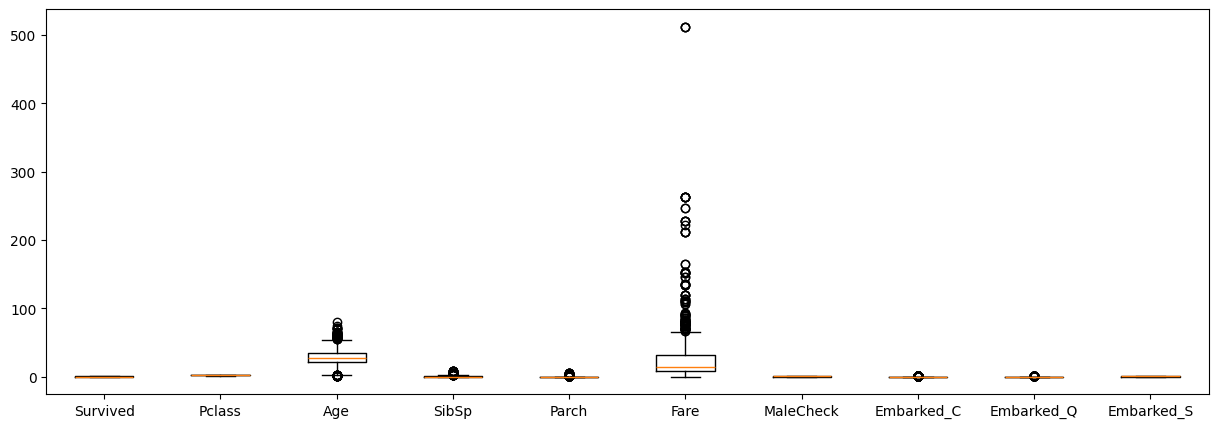

In [59]:
%matplotlib inline
# Visualizando a escala desses dados
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(treino.iloc[:,1:11])
ax.set_xticks(range(1,treino.iloc[:,1:11].shape[1]+1),treino.iloc[:,1:11].columns)

plt.show()

### RobustScaler

- O RobustScaler é uma técnica de escala robusta, utilizada como parte do pré-processamento de dados em aprendizado de máquina. Ao contrário de escaladores tradicionais, como o StandardScaler, o RobustScaler é menos sensível à presença de valores discrepantes (outliers) nos dados.

- A principal função do RobustScaler é ajustar e transformar os dados de forma que a mediana seja 0 e a variação (range interquartil) seja 1. Isso é especialmente útil quando os dados contêm valores atípicos que podem distorcer a escala padrão.

- Essa abordagem é valiosa em situações em que a presença de outliers pode afetar negativamente o desempenho de técnicas que assumem normalidade nos dados, como regressão linear e k-means clustering. O RobustScaler ajuda a mitigar o impacto desses outliers na escala dos dados.

    - A técnica será aplicada em colunas em que há uma forte presença de outliers, conforme o gráfico acima

In [60]:
from sklearn.preprocessing import RobustScaler

In [61]:
# Criando o scaler
transformer = RobustScaler().fit(treino[['Age','Fare']])

In [62]:
# Fazendo o transformação dos dados
treino[['Age','Fare']] = transformer.transform(treino[['Age','Fare']])

In [63]:
# Fazendo o mesmo para a base de teste
transformer = RobustScaler().fit(teste[['Age','Fare']])
teste[['Age','Fare']] = transformer.transform(teste[['Age','Fare']])

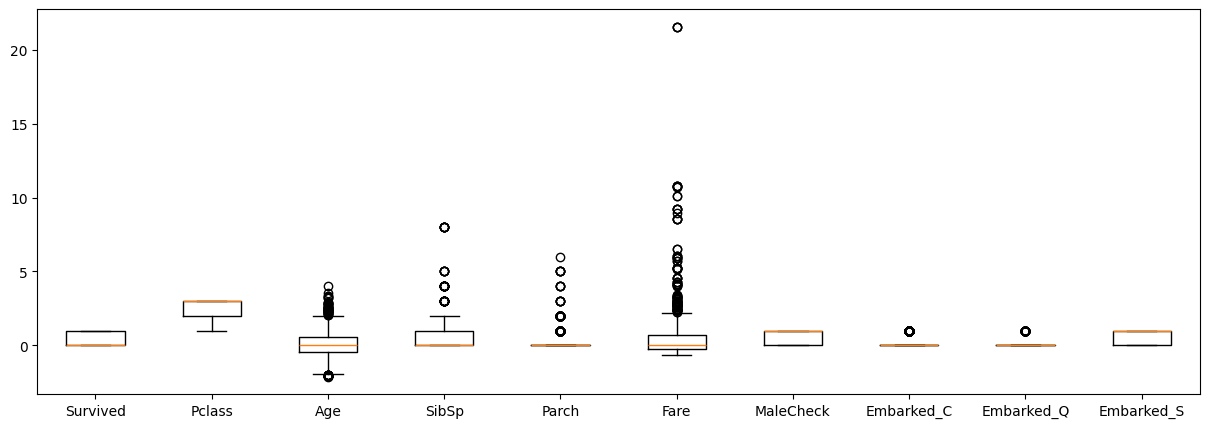

In [64]:
# Visualizando novamente os dados
fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(treino.iloc[:,1:11])
ax.set_xticks(range(1,treino.iloc[:,1:11].shape[1]+1),treino.iloc[:,1:11].columns)

plt.show()

### Avaliando novo modelo (com RobustScaler)

In [73]:
X = treino.drop(['PassengerId','Survived'],axis=1)
# A tabela abaixo atribui o resultado que esperamos, para verificar se há um modelo que possa prever os sobreviventes.
y = treino.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

# Criando o classificador
# clf -> classificação
# ac -> arvore de classificação
clf_ac = tree.DecisionTreeClassifier()

# Fazendo o fit com os dados (treinando o modelo)
clf_ac = clf_ac.fit(X_train,y_train)

y_pred_ac = clf_ac.predict(X_val)

# Criando o classificador
# clf -> classificação
# knn -> modelo usado (kneighborsclassifier)
clf_knn = KNeighborsClassifier(n_neighbors=3)

# Fazendo o fit com os dados (treinando o modelo)
clf_knn = clf_knn.fit(X_train,y_train)

y_pred_knn = clf_knn.predict(X_val)

# Criando o classificador
# clf -> classificador
# rl -> Regressão Logística
clf_rl = LogisticRegression(max_iter=1000)

# Fazendo o fit com os dados (treinando o modelo)
clf_rl = clf_rl.fit(X_train,y_train)

y_pred_rl = clf_rl.predict(X_val)

as_ac = accuracy_score(y_val, y_pred_ac) # Verificando acurácia para a árvore de classificação
as_knn = accuracy_score(y_val, y_pred_knn) # Verificando acurácia para o knn
as_rl = accuracy_score(y_val, y_pred_rl) # Para a regressão logística

print(as_ac, as_knn, as_rl)

0.7830508474576271 0.8135593220338984 0.8101694915254237


In [74]:
as_df['escala'] = [as_ac,as_knn,as_rl]

In [75]:
as_df.head()

,modelos,inicial,escala
0,arvore,0.762712,0.783051
1,knn,0.694915,0.813559
2,reg. log.,0.810169,0.810169


#### Entendendo as colunas SibSp e Parch
- Agora podemos entender as colunas **SibSp** e **Parch**
    - **SibSp**: Nº de irmãos/cônjuges a bordo do Titanic
    - **Parch**: Nº de pais/filhos a bordo do Titanic
- Podemos verificar quantas pessoas sobreviveram em cada um dos valores dessa coluna

In [76]:
# Verificando a sobrevivência para SibSp
SibSp_df = treino.groupby('SibSp')['Survived'].agg(['sum','count','mean']).reset_index()
SibSp_df.columns = ['SibSp','sobrev','total','tx_sobrev']
SibSp_df

,SibSp,sobrev,total,tx_sobrev
0,0,210,608,0.345395
1,1,112,209,0.535885
2,2,13,28,0.464286
3,3,4,16,0.250000
4,4,3,18,0.166667
5,5,0,5,0.000000
6,8,0,7,0.000000


In [77]:
# Verificando a sobrevivência para Parch
Parch_df = treino.groupby('Parch')['Survived'].agg(['sum','count','mean']).reset_index()
Parch_df.columns = ['Parch','sobrev','total','tx_sobrev']
Parch_df

,Parch,sobrev,total,tx_sobrev
0,0,233,678,0.343658
1,1,65,118,0.550847
2,2,40,80,0.500000
3,3,3,5,0.600000
4,4,0,4,0.000000
5,5,1,5,0.200000
6,6,0,1,0.000000


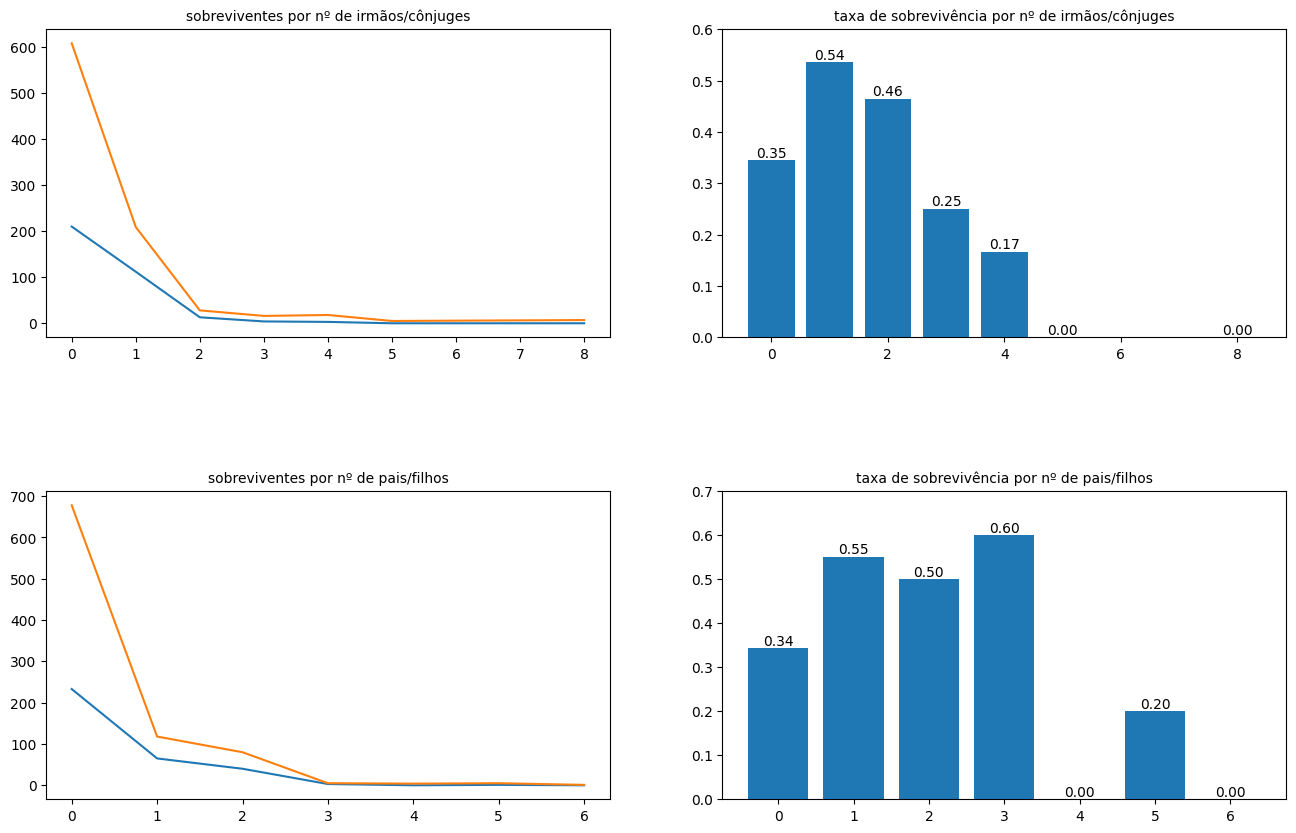

In [79]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(16,10))

ax[0,0].plot(SibSp_df.SibSp, SibSp_df.sobrev)
ax[0,0].plot(SibSp_df.SibSp, SibSp_df.total)
ax[0,0].set_title('sobreviventes por nº de irmãos/cônjuges', fontsize=10)

labels1 = ax[0,1].bar(SibSp_df.SibSp, SibSp_df.tx_sobrev)
ax[0,1].bar_label(labels1,fmt="%.02f")
ax[0,1].set(ylim=(0,0.6))
ax[0,1].set_title('taxa de sobrevivência por nº de irmãos/cônjuges', fontsize=10)

ax[1,0].plot(Parch_df.Parch, Parch_df.sobrev)
ax[1,0].plot(Parch_df.Parch, Parch_df.total)
ax[1,0].set_title('sobreviventes por nº de pais/filhos', fontsize=10)

labels2 = ax[1,1].bar(Parch_df.Parch, Parch_df.tx_sobrev)
ax[1,1].bar_label(labels2,fmt="%.02f")
ax[1,1].set(ylim=(0,0.7))
ax[1,1].set_title('taxa de sobrevivência por nº de pais/filhos', fontsize=10)

plt.subplots_adjust(hspace=0.5)

plt.show()

- **Passageiros viajando sozinho tiveram um menor percentual de sobrevivência**
    - Vamos criar uma nova coluna identificando se o passageiro está viajando sozinho

In [80]:
# Criando uma função para verificar se os dois valores são vazios
def sozinho(a,b):
    if (a == 0 and b == 0):
        return 1
    else:
        return 0

In [81]:
# Aplicando essa função na base de treino
treino['Sozinho'] = treino.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)

In [82]:
treino.groupby('Sozinho')[['SibSp','Parch']].mean()

,SibSp,Parch
Sozinho,,
0,1.316384,0.960452
1,0.000000,0.000000


In [83]:
# Para a base de teste
teste['Sozinho'] = teste.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)

In [85]:
teste.groupby('Sozinho')[['SibSp','Parch']].mean()

,SibSp,Parch
Sozinho,,
0,1.133333,0.993939
1,0.000000,0.000000


- Podemos também **criar uma nova coluna** sendo o **total de familiares a bordo**

In [87]:
# Criando para a base de treino e teste
treino['Familiares'] = treino.SibSp + treino.Parch
teste['Familiares'] = treino.SibSp + treino.Parch

In [88]:
Familiares_df = treino.groupby('Familiares')['Survived'].agg(['sum','count','mean']).reset_index()
Familiares_df.columns = ['Familiares','sobrev','total','tx_sobrev']
Familiares_df

,Familiares,sobrev,total,tx_sobrev
0,0,163,537,0.303538
1,1,89,161,0.552795
2,2,59,102,0.578431
3,3,21,29,0.724138
4,4,3,15,0.200000
5,5,3,22,0.136364
6,6,4,12,0.333333
7,7,0,6,0.000000
8,10,0,7,0.000000


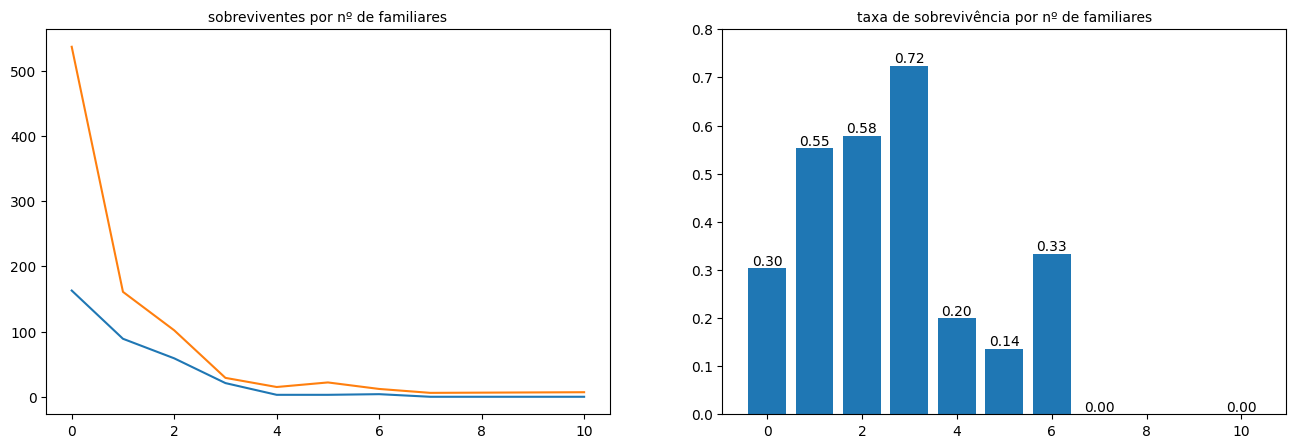

In [91]:
# Visualizando a informação de familiares
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].plot(Familiares_df.Familiares, Familiares_df.sobrev)
ax[0].plot(Familiares_df.Familiares, Familiares_df.total)
ax[0].set_title('sobreviventes por nº de familiares', fontsize=10)

labels1 = ax[1].bar(Familiares_df.Familiares, Familiares_df.tx_sobrev)
ax[1].bar_label(labels1,fmt="%.02f")
ax[1].set(ylim=(0,0.8))
ax[1].set_title('taxa de sobrevivência por nº de familiares', fontsize=10)

plt.show()

### Avaliando nova acurácia (com a engenharia de atributos)

In [92]:
X = treino.drop(['PassengerId','Survived'],axis=1)
# A tabela abaixo atribui o resultado que esperamos, para verificar se há um modelo que possa prever os sobreviventes.
y = treino.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

# Criando o classificador
# clf -> classificação
# ac -> arvore de classificação
clf_ac = tree.DecisionTreeClassifier()

# Fazendo o fit com os dados (treinando o modelo)
clf_ac = clf_ac.fit(X_train,y_train)

y_pred_ac = clf_ac.predict(X_val)

# Criando o classificador
# clf -> classificação
# knn -> modelo usado (kneighborsclassifier)
clf_knn = KNeighborsClassifier(n_neighbors=3)

# Fazendo o fit com os dados (treinando o modelo)
clf_knn = clf_knn.fit(X_train,y_train)

y_pred_knn = clf_knn.predict(X_val)

# Criando o classificador
# clf -> classificador
# rl -> Regressão Logística
clf_rl = LogisticRegression(max_iter=1000)

# Fazendo o fit com os dados (treinando o modelo)
clf_rl = clf_rl.fit(X_train,y_train)

y_pred_rl = clf_rl.predict(X_val)

as_ac = accuracy_score(y_val, y_pred_ac) # Verificando acurácia para a árvore de classificação
as_knn = accuracy_score(y_val, y_pred_knn) # Verificando acurácia para o knn
as_rl = accuracy_score(y_val, y_pred_rl) # Para a regressão logística

print(as_ac, as_knn, as_rl)

0.7830508474576271 0.7559322033898305 0.7864406779661017


In [93]:
as_df['pessoas'] = [as_ac,as_knn,as_rl]

In [94]:
as_df

,modelos,inicial,escala,pessoas
0,arvore,0.762712,0.783051,0.783051
1,knn,0.694915,0.813559,0.755932
2,reg. log.,0.810169,0.810169,0.786441


- As modificações feitas regrediram a acurácia do nosso modelo de previsão. Vamos entender melhor quais colunas são mais eficientes para serem usadas na previsão do modelo

#### Selecionando os melhores recursos
- Primeiramente vamos analisar qual a **correlação entre as variáveis** e verificar se não existem variáveis que estão "dizendo a mesma coisa"

In [95]:
treino.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
0,1,0,3,-0.461538,1,0,-0.312011,1,0,0,1,0,1
1,2,1,1,0.769231,1,0,2.461242,0,1,0,0,0,1
2,3,1,3,-0.153846,0,0,-0.282777,0,0,0,1,1,0
3,4,1,1,0.538462,1,0,1.673732,0,0,0,1,0,1
4,5,0,3,0.538462,0,0,-0.277363,1,0,0,1,1,0


In [96]:
treino.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S,Sozinho,Familiares
PassengerId,1.000000,-0.005007,-0.035144,0.034212,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022204,0.057462,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.149683,-0.203367,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.074053,0.135207,0.065997
Age,0.034212,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,0.081163,0.030248,-0.031415,-0.006729,0.171647,-0.245619
SibSp,-0.057527,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.068734,-0.584471,0.890712
Parch,-0.001652,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.060814,-0.583398,0.783111
Fare,0.012658,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.162184,-0.271832,0.217138
MaleCheck,0.042939,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.119224,0.303646,-0.200988
Embarked_C,-0.001205,0.168240,-0.243292,0.030248,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.782742,-0.095298,-0.046215
Embarked_Q,-0.033606,0.003650,0.221009,-0.031415,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.499421,0.086464,-0.058592


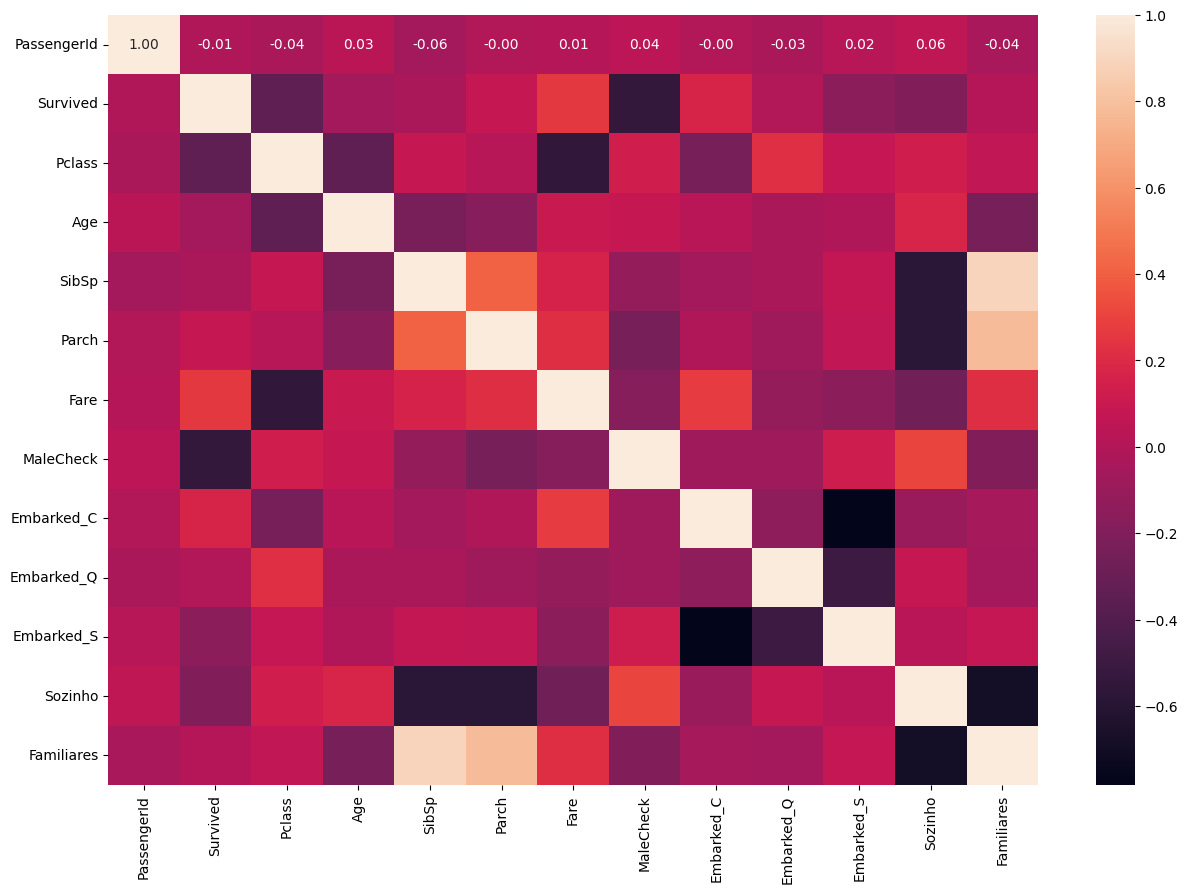

In [100]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(treino.corr(), annot=True, fmt=".2f")

plt.show()

- Vamos se aprofundas nas relações entre as colunas Pclass e Fare

c:\Users\Lucas\OneDrive\Documentos\avancandoPython\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lucas\OneDrive\Documentos\avancandoPython\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lucas\OneDrive\Documentos\avancandoPython\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lucas\OneDrive\Documentos\avancandoPython\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

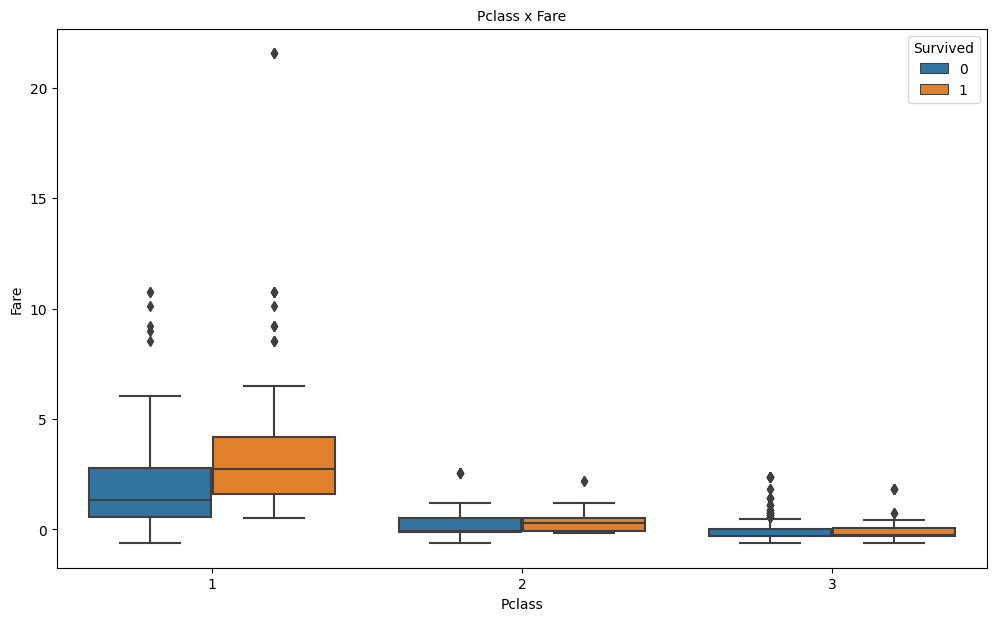

In [106]:
%matplotlib inline
# Visualizando a relação entre essas variáveis
fig, ax = plt.subplots(figsize=(12,7))

sns.boxplot(data=treino,x='Pclass',y='Fare',hue='Survived')
ax.set_title('Pclass x Fare', fontsize=10)

plt.show()

In [109]:
# Verificando a taxa de sobrevivência em cada uma das classes
treino.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [110]:
# Entendendo a relação entre Pclass x Fare
treino.groupby(['Pclass','Survived'])['Fare'].agg(['min','mean','max'])

min      mean        max
Pclass Survived                               
1      0        -0.626005  2.175430  10.764405
       1         0.496977  3.514735  21.562738
2      0        -0.626005  0.214734   2.557247
       1        -0.171255  0.329217   2.189115
3      0        -0.626005 -0.033991   2.386174
       1        -0.626005 -0.032885   1.820802

- Nesse momento pode surgir a pergunta do motivo de termos **pessoas pagando o mesmo preço em classes diferentes**
    - Procurando no Kaggle, (https://www.kaggle.com/questions-and-answers/128215) ajuda a explicar um pouco:


_"Se você conseguiu economizar e guardar todo o seu dinheiro para uma viagem para mudar sua vida e ir para a América, você é uma terceira classe, um imigrante que precisa trazer sua própria comida a bordo e ter em mente como suas provisões se sustentariam. A segunda classe era formada por trabalhadores de colarinho branco que podiam se dar ao luxo de viajar com um pouco de lazer, sem se preocupar com algo tão comum como comida. Primeira classe significa que você nasceu com dinheiro e não precisa sujar as mãos com o trabalho. Eles não eram separados apenas pelo custo, eles também eram separados por onde poderiam ir e o que recebiam."_ 

- Também tem um link do Reddit que detalha bem essa questão de classe x preço
    - https://www.reddit.com/r/AskHistorians/comments/11dlsn6/why_was_the_cost_of_tickets_on_the_titanic_so/?onetap_auto=true
    - Podemos pensar em direcionar uma **análise relacionando ao preço da cabine**, porém **essa variável possui 77.1% dos valores vazios**

- Entendendo sobre as **colunas de embarque**
    - Inicialmente pensamos não existir relação de ordem entre a coluna de embarque, mas pesquisando [nesse artigo](https://pt.wikipedia.org/wiki/RMS_Titanic) percebemos que **existe sim essa correlação**
    
    
_"O Titanic deixou o porto de **Southampton**...Em seguida ele foi para **Cherbourg-Octeville** na França...em sua maioria da primeira classe.O Titanic então rumou para **Queenstown** na Irlanda...principalmente imigrantes da terceira classe que pretendiam tentar a vida nos Estados Unidos."_ 

In [111]:
# Podemos importar novamente as bases para "recuperar" a coluna de embarque
treino2 = pd.read_csv('train.csv')
teste2 = pd.read_csv('test.csv')

In [112]:
# Como temos valores vazios, podemos novamente fazer o tratamento dos dados
treino2['Embarked'] = treino2['Embarked'].fillna('S')

- O que podemos fazer agora é colocar o porto em ordem de embarque (S depois C e depois Q)
    - Podemos fazer isso através do OrdinalEncoder (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

- O OrdinalEncoder é utilizado para codificar variáveis categóricas ordinais em números inteiros.

- Em contextos de aprendizado de máquina, muitos algoritmos exigem que os dados de entrada sejam numéricos. Quando lidamos com variáveis categóricas ordinais, ou seja, aquelas que têm uma ordem específica (por exemplo, "baixo", "médio", "alto"), precisamos convertê-las em representações numéricas.

In [113]:
from sklearn.preprocessing import OrdinalEncoder

In [114]:
categorias = ['S','C','Q']

enc = OrdinalEncoder(categories=[categorias],dtype='int32')

In [115]:
# Fazendo o fit com os dados
enc = enc.fit(treino2[['Embarked']])

In [116]:
treino['Embarked'] = enc.transform(treino2[['Embarked']])

In [117]:
# E fazer o fit com os dados de teste
enc = enc.fit(teste2[['Embarked']])

In [118]:
# E adicionar na base de teste original
teste['Embarked'] = enc.transform(teste2[['Embarked']])

In [119]:
# Agora podemos eliminar as colunas desnecessárias
treino = treino.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis=1)
teste = teste.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis=1)

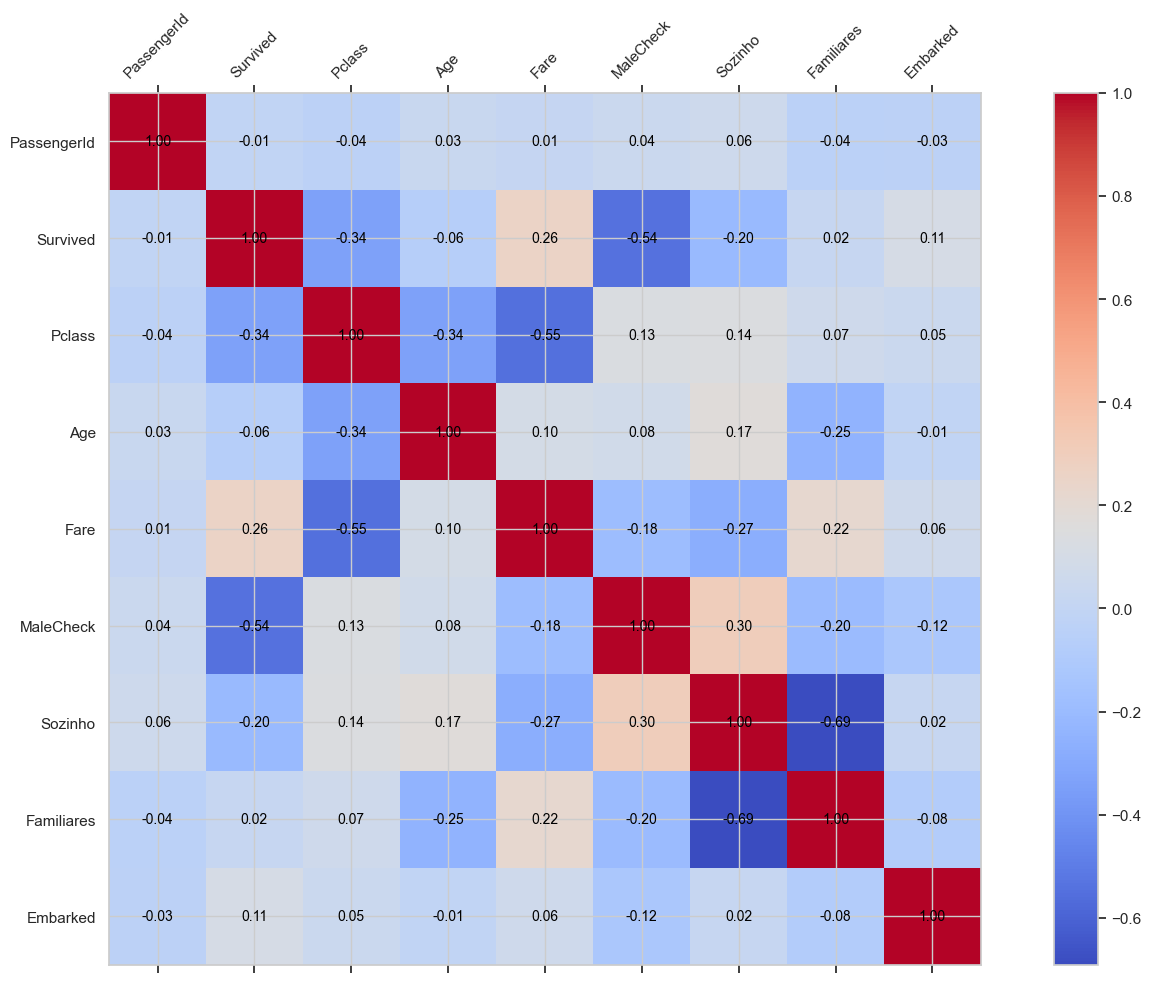

In [148]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 10))

cax = ax.matshow(treino.corr(), cmap='coolwarm')
plt.xticks(np.arange(len(treino.columns)), treino.columns, rotation=45)
plt.yticks(np.arange(len(treino.columns)), treino.columns)

# Adicionar as anotações
for i in range(len(treino.columns)):
    for j in range(len(treino.columns)):
        text = ax.text(j, i, f'{treino.corr().iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

# Adicionar a barra de cores
fig.colorbar(cax)

plt.tight_layout()
plt.show()


- Entendendo agora as colunas de família
    - Podemos usar a regressão logística e a árvore de classificação para verificar a importância de cada uma dessas colunas

In [140]:
# Separando X e y
X = treino.drop(['PassengerId','Survived'],axis=1)
y = treino.Survived

In [141]:
# Usando a regressão logística nos dados
clf_rl = LogisticRegression(random_state=42,max_iter=1000).fit(X,y)

In [142]:
# Verificando a importância
clf_rl.coef_[0]

array([-1.0326742 , -0.49033135, -0.26896741,  0.01826545,  0.04455768,
       -2.53497767, -0.74102503, -0.25070196,  0.2245328 ])

In [143]:
# Agora usando a árvore de classificação
clf_ac = tree.DecisionTreeClassifier(random_state=42).fit(X,y)

In [144]:
# Verificando a importância
clf_ac.feature_importances_

array([0.11058368, 0.22406348, 0.03971085, 0.02130199, 0.23942842,
       0.31088095, 0.0073744 , 0.02170496, 0.02495127])

In [145]:
imp = pd.DataFrame({
    'colunas': X.columns,
    'reg. log.': clf_rl.coef_[0],
    'arvore': clf_ac.feature_importances_
})

imp

,colunas,reg. log.,arvore
0,Pclass,-1.032674,0.110584
1,Age,-0.490331,0.224063
2,SibSp,-0.268967,0.039711
3,Parch,0.018265,0.021302
4,Fare,0.044558,0.239428
5,MaleCheck,-2.534978,0.310881
6,Sozinho,-0.741025,0.007374
7,Familiares,-0.250702,0.021705
8,Embarked,0.224533,0.024951


In [146]:
# Podemos apenas manter as colunas mais relevantes
treino = treino.drop(['SibSp','Parch'],axis=1)
teste = teste.drop(['SibSp','Parch'],axis=1)

### Realizando teste dos modelos após desclassificar colunas de menor correlação

In [149]:
X = treino.drop(['PassengerId','Survived'],axis=1)
# A tabela abaixo atribui o resultado que esperamos, para verificar se há um modelo que possa prever os sobreviventes.
y = treino.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

# Criando o classificador
# clf -> classificação
# ac -> arvore de classificação
clf_ac = tree.DecisionTreeClassifier()

# Fazendo o fit com os dados (treinando o modelo)
clf_ac = clf_ac.fit(X_train,y_train)

y_pred_ac = clf_ac.predict(X_val)

# Criando o classificador
# clf -> classificação
# knn -> modelo usado (kneighborsclassifier)
clf_knn = KNeighborsClassifier(n_neighbors=3)

# Fazendo o fit com os dados (treinando o modelo)
clf_knn = clf_knn.fit(X_train,y_train)

y_pred_knn = clf_knn.predict(X_val)

# Criando o classificador
# clf -> classificador
# rl -> Regressão Logística
clf_rl = LogisticRegression(max_iter=1000)

# Fazendo o fit com os dados (treinando o modelo)
clf_rl = clf_rl.fit(X_train,y_train)

y_pred_rl = clf_rl.predict(X_val)

as_ac = accuracy_score(y_val, y_pred_ac) # Verificando acurácia para a árvore de classificação
as_knn = accuracy_score(y_val, y_pred_knn) # Verificando acurácia para o knn
as_rl = accuracy_score(y_val, y_pred_rl) # Para a regressão logística

print(as_ac, as_knn, as_rl)

0.8 0.8033898305084746 0.8135593220338984


In [150]:
as_df['colunas'] = [as_ac,as_knn,as_rl]

In [151]:
as_df

,modelos,inicial,escala,pessoas,colunas
0,arvore,0.762712,0.783051,0.783051,0.800000
1,knn,0.694915,0.813559,0.755932,0.803390
2,reg. log.,0.810169,0.810169,0.786441,0.813559


- Dessa maneira, conclumos que o melhor modelo é o de regressão logistica, com alteração a exclusão de colunas menos correlacionadas

In [152]:
X_train.head()

,Pclass,Age,Fare,MaleCheck,Sozinho,Familiares,Embarked
407,2,-1.923077,0.186049,1,0,2,0
593,3,0.000000,-0.290356,0,0,2,2
781,1,-0.846154,1.842639,0,0,1,0
197,3,1.076923,-0.262023,1,0,1,0
490,3,0.000000,0.238744,1,0,1,0


In [153]:
teste.head()

,PassengerId,Pclass,Age,Fare,MaleCheck,Sozinho,Familiares,Embarked
0,892,3,0.588235,-0.280670,1,1,1,2
1,893,3,1.568627,-0.315800,0,0,1,0
2,894,2,2.745098,-0.201943,1,1,0,2
3,895,3,0.000000,-0.245367,1,1,1,0
4,896,3,-0.392157,-0.091793,0,0,0,0


In [154]:
X_teste = teste.drop('PassengerId',axis=1)

In [155]:
y_pred = clf_rl.predict(X_teste)

In [156]:
teste['Survived'] = y_pred

In [157]:
base_envio = teste[['PassengerId','Survived']]

In [158]:
base_envio.to_csv('resultados_colunas.csv',index=False)